In [1]:
import io
import os
import pickle
import random as rn
import warnings
from importlib import reload
from multiprocessing import cpu_count

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from gensim.models import Word2Vec
from IPython.display import display
from sklearn.metrics import accuracy_score, f1_score, hamming_loss, \
        average_precision_score, ndcg_score, \
        label_ranking_average_precision_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import shuffle
from tensorflow.distribute import MirroredStrategy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant, GlorotUniform
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, Conv1D, \
        GlobalMaxPooling1D, SpatialDropout1D, LSTM, GRU, Flatten, MaxPooling1D, \
        BatchNormalization, ReLU, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import data
import models
import preprocessing

seed = 42
sns.set()

def reset_seed():
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    np.random.seed(seed)
    rn.seed(seed)
    tf.random.set_seed(seed)

## Extracting the data

In [2]:
# data.extract_data(extraction_dir="train",
#                   data_dir="data",
#                   data_zip_name="reuters-training-corpus.zip")

train_df = pd.read_pickle("train/data.pkl")

# train_df = data.get_docs_labels("train/REUTERS_CORPUS_2")
# train_df.to_pickle("train/data.pkl")

train_docs = train_df["doc"].values
train_labels = np.array(train_df["labels"].tolist())
n_labels = len(data.CODEMAP)

print(train_docs.shape)
print(train_labels.shape)
print(train_docs[2])
print(train_labels[2])

(299773,)
(299773, 126)
Toronto stocks end higher after volatile session. CHANGE				    CHANGE TSE	  5900.37    +50.15   HI 5900.37	    LO  5840.29 DJI	  6611.05    +27.57   GOLD (LONDON)   US$350.00 +1.90 FTSE100    4248.10    -64.80   GOLD (NY-COMEX) US$354.80 +0.70 NIKKEI    17869.59   -133.81   LME CASH NICKEL US$7659   +99.0 CANDLR	1.3883		 LME CASH ALUM   US$1602.0  -4.0 CAN 30-YR   107.41     -0.15   BRENT CRUDE     US$19.09  -0.27 --------------------MARKET COMMENT---------------------------- * Toronto stocks ended higher on Tuesday, buoyed by strength in golds and banking * Computer problems due to heavy trading in Bre-X Minerals hampered session * 84 million shares traded Toronto's key stock index ended higher on Tuesday as the saga of Bre-X Minerals Ltd and its Indonesian gold find continued to dominate Canada's biggest stock market. The TSE 300 Index climbed 50.15 points to close at 5900.37 in heavy turnover of 84.07 million shares worth C$1.4 billion. But the overall marke

## Preprocessing the documents

In [3]:
path_to_preprocessed_train_docs = "train/preprocessed_docs.pkl" # tokenization only
# path_to_preprocessed_train_docs = "train/preprocessed_docs_lemmatized_no_sw.pkl"

with open(path_to_preprocessed_train_docs, "rb") as f:
    preprocessed_train_docs = pickle.load(f)

# preprocessed_train_docs = preprocessing.preprocess_corpus(train_docs)
# with open(path_to_preprocessed_train_docs, "wb") as f:
#     pickle.dump(preprocessed_train_docs, f)

print(preprocessed_train_docs[2])

Toronto stocks end higher after volatile session . CHANGE CHANGE TSE 5900.37 +50.15 HI 5900.37 LO 5840.29 DJI 6611.05 +27.57 GOLD ( LONDON ) US$ 350.00 +1.90 FTSE100 4248.10 -64.80 GOLD ( NY - COMEX ) US$ 354.80 +0.70 NIKKEI 17869.59 -133.81 LME CASH NICKEL US$ 7659 +99.0 CANDLR 1.3883 LME CASH ALUM US$ 1602.0 -4.0 CAN 30-YR 107.41 -0.15 BRENT CRUDE US$ 19.09 -0.27 --------------------MARKET COMMENT---------------------------- * Toronto stocks ended higher on Tuesday , buoyed by strength in golds and banking * Computer problems due to heavy trading in Bre - X Minerals hampered session * 84 million shares traded Toronto 's key stock index ended higher on Tuesday as the saga of Bre - X Minerals Ltd and its Indonesian gold find continued to dominate Canada 's biggest stock market . The TSE 300 Index climbed 50.15 points to close at 5900.37 in heavy turnover of 84.07 million shares worth C$ 1.4 billion . But the overall market was mixed with declining issues narrowly outpacing advances 476

## Representing the documents as token index sequences

In [4]:
docs = preprocessed_train_docs
n_vocabulary = 100000

In [5]:
tokenizer = Tokenizer(num_words=n_vocabulary, filters="", lower=False)
tokenizer.fit_on_texts(docs)
word_idx = tokenizer.word_index
if n_vocabulary is None:
    n_vocabulary = len(word_idx)

print(n_vocabulary)

100000


In [6]:
n_sequence = 768

sequences = tokenizer.texts_to_sequences(docs)
if n_sequence is None:
    n_sequence = max([len(s) for s in sequences])
sequence_lengths = [min(len(s), n_sequence) for s in sequences]
sequences = pad_sequences(sequences,
                          maxlen=n_sequence,
                          padding="post",
                          truncating="post")

print(n_sequence)
print(sequences.shape)
print(sequences[2][:100])

768
(299773, 768)
[ 2112   217   137   145    52  2639   593     2  3714  3714  9473  8514
  9051 30534  4802    14  2981    13   587 22026 55200  4802    14  3274
     7  3355    13   587 66463 15304  1660  5594 16940   587 24154  1660
  5594 23347   587 14783  1709 11671 34203 15729 13077   587 40699 46144
 32689 36483    38  2112   217   226   145    12    85     3  5774    23
  1043     6 11672     9   809    38  3318   700   167     4   901   181
     6  3495     7  1927  6603  9271   593    38  4214    31    75   418
  2112    15   435   150   180   226   145    12    85    30     1 15801
     5  3495     7  1927]


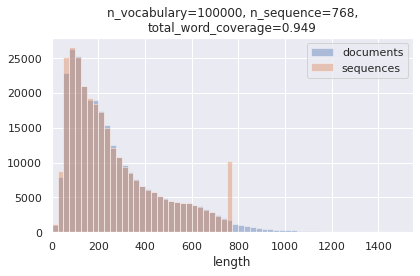

In [7]:
doc_lengths = [len(doc.split()) for doc in docs]

sns.distplot(doc_lengths,
             bins=np.arange(0, 2500, 25),
             kde=False,
             label="documents")
sns.distplot(sequence_lengths,
             bins=np.arange(0, 2500, 25),
             kde=False,
             label="sequences")
total_word_coverage = np.round(np.sum(sequence_lengths) / np.sum(doc_lengths), 3)
plt.title(f"n_vocabulary={n_vocabulary}, n_sequence={n_sequence},\n"
          f"total_word_coverage={total_word_coverage}")
plt.xlim(0, 1550)
plt.xlabel("length")
plt.legend()
plt.tight_layout()
plt.show()

## Word embeddings

In [8]:
n_embedding = 300 # 300 required by FastText

### Word2Vec

In [9]:
reset_seed()

window = 5
w2v_path = f"data/w2v_{window}_{n_embedding}_train.model"

try:
    w2v_embedding_model = Word2Vec.load(w2v_path)
except:
    w2v_embedding_model = Word2Vec(sentences=[s.split() for s in docs],
                                   size=n_embedding, 
                                   window=window,
                                   min_count=5,
                                   sg=1,
                                   workers=cpu_count(),
                                   seed=seed)
    w2v_embedding_model.save(w2v_path)

print(len(list(w2v_embedding_model.wv.vocab)))
print(w2v_embedding_model.wv.index2entity[:100])

191252
['the', '.', ',', 'to', 'of', 'in', '-', 'a', 'and', '"', 'said', 'on', ')', '(', "'s", 'for', 'The', 'at', 'was', '$', 'that', 'is', 'by', 'with', 'from', 'percent', 'it', 'be', '/', 'as', 'million', 'its', 'will', 'has', '--', 'were', 'not', '*', 'would', 'year', 'are', 'have', 'an', 'he', 'which', ':', 'had', 'market', 'up', 'A', 'but', 'after', 'N', 'this', 'company', 'one', 'been', 'U.S.', 'billion', 'also', 'government', 'last', 'or', '1997', 'two', 'their', 'they', 'first', 'over', 'new', '1', 'his', 'more', 'June', 'shares', 'about', 'week', 'It', 'than', 'share', 'Bank', 'who', 'I', '1996', 'Tuesday', '%', 'per', 'Wednesday', 'May', 'we', 'expected', 'July', 'Thursday', 'Monday', 'We', 'some', 'Friday', 'down', 'could', 'three']


### FastText

In [10]:
def load_vectors(fname): # from https://fasttext.cc/docs/en/english-vectors.html
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.array(list(map(float, tokens[1:])))
    return data

ft_embedding_model = load_vectors("data/crawl-300d-2M.vec")

token_iter = iter(ft_embedding_model)
print([next(token_iter) for i in range(100)])

[',', 'the', '.', 'and', 'to', 'of', 'a', 'in', 'is', 'for', 'that', 'I', 'it', 'on', 'with', ')', ':', '"', '(', 'The', 'you', 'was', 'are', 'or', 'this', 'as', 'have', 'at', 'from', '!', "'s", 'but', 'by', 'not', '?', 'your', 'all', '/', 'be', 'we', 'my', 'one', '-', 'will', 'they', 'so', 'which', '”', '“', 'has', '...', 'just', 'he', 'their', 'can', 'about', 'his', 'our', ';', 'when', 'more', 'had', 'do', 'some', 'time', 'like', 'also', 'there', 'them', 'get', 'what', 'out', "'", 'me', 'her', 'an', 'were', 'This', 'It', 'up', 'would', 'if', 'who', 'new', 'only', 'A', '–', 'people', 'any', 'We', 'make', 'other', 'In', 'then', 'its', 'use', 'said', 'now', 'no', 'first']


### Embedding matrices

In [11]:
def create_embedding_matrix(embedding_model):
    embedding_matrix = np.zeros((n_vocabulary, n_embedding))
    unknown_token_count = 0
    for token, i in word_idx.items():
        if i >= n_vocabulary:
            continue
        if token in embedding_model:
            embedding_matrix[i] = embedding_model[token]
        else:
            embedding_matrix[i] = np.zeros(n_embedding)
            unknown_token_count += 1

    print(unknown_token_count)
    print(embedding_matrix.shape)
    print(embedding_matrix[1][:50])

    return embedding_matrix

In [12]:
w2v_embedding_matrix = create_embedding_matrix(w2v_embedding_model)

0
(100000, 300)
[ 0.0552584   0.01123355  0.05852774  0.03515947  0.11631026 -0.02895849
  0.17440622 -0.07505921  0.31014937  0.18220782 -0.153667    0.12877345
 -0.16599374 -0.03246057  0.14044979  0.0378183   0.01423781  0.20776965
  0.25640684 -0.29507896  0.05467122 -0.19314985  0.16100715  0.16121837
  0.10513832 -0.14126474 -0.10564382  0.07230753 -0.2635389   0.11694992
  0.22365659  0.10568991 -0.20522533 -0.00804843 -0.11998951  0.02327573
  0.23315957 -0.22042817 -0.04073263 -0.07091328 -0.26871315  0.40764555
 -0.12853378 -0.1205063  -0.04120149 -0.03833532  0.09974524 -0.1054061
 -0.04243345 -0.16846807]


In [13]:
ft_embedding_matrix = create_embedding_matrix(ft_embedding_model)

16437
(100000, 300)
[ 0.0231  0.017   0.0157 -0.0773  0.1088  0.0031 -0.1487 -0.2672 -0.0357
 -0.0487  0.0807  0.1532 -0.0739 -0.0291 -0.0445 -0.0014  0.1014  0.0186
 -0.0253  0.02   -0.0026 -0.0179  0.0005  0.0054 -0.0134  0.0233 -0.0755
 -0.0156  0.0415 -0.4985  0.041  -0.0616  0.0047  0.0325 -0.0162 -0.0172
  0.0988  0.0766 -0.0796 -0.0345  0.0124 -0.1007 -0.0292 -0.0762 -0.1261
 -0.0531  0.0424  0.0144 -0.0683  0.2859]


## Shuffling the data

In [14]:
n_samples = None
x_train, y_train = shuffle(sequences,
                           train_labels,
                           random_state=seed,
                           n_samples=n_samples)

## Cross-evaluating the models

In [15]:
def cross_evaluate(model_initializer, embedding_matrix, loss, batch_size=256):
    kfold = KFold(n_splits=5)
    cv_scores = []

    model_initializer(embedding_matrix, n_vocabulary, n_embedding, n_sequence,
                      n_labels, loss).summary()

    for train, val in kfold.split(x_train, y_train):
        model = model_initializer(embedding_matrix, n_vocabulary, n_embedding,
                                  n_sequence, n_labels, loss)
        es = EarlyStopping(patience=3, verbose=1, restore_best_weights=True)
        history = model.fit(x_train[train],
                            y_train[train],
                            batch_size=batch_size,
                            epochs=100,
                            verbose=1,
                            validation_data=(x_train[val], y_train[val]),
                            callbacks=[es])

        y_pred_prob = model.predict(x_train[val], batch_size=batch_size, verbose=1)
        y_pred = np.round(y_pred_prob)

        scores = {}
        scores["accuracy"] = accuracy_score(y_train[val], y_pred)
        scores["F1 (macro)"] = f1_score(y_train[val], y_pred, average="macro")
        scores["F1 (micro)"] = f1_score(y_train[val], y_pred, average="micro")
        scores["LRAP"] = label_ranking_average_precision_score(y_train[val],
                                                               y_pred_prob)
        scores["NDCG"] = ndcg_score(y_train[val], y_pred_prob)
        cv_scores.append(scores)
        print(scores)

    cv_scores_df = pd.DataFrame(cv_scores)
    display(cv_scores_df)
    print(cv_scores_df.mean())

In [83]:
reset_seed()
cross_evaluate(models.init_cnn_1, ft_embedding_matrix, "mean_squared_error")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_54 (Embedding)     (None, 768, 300)          30000000  
_________________________________________________________________
conv1d_111 (Conv1D)          (None, 767, 300)          180300    
_________________________________________________________________
batch_normalization_111 (Bat (None, 767, 300)          1200      
_________________________________________________________________
max_pooling1d_111 (MaxPoolin (None, 383, 300)          0         
_________________________________________________________________
dropout_114 (Dropout)        (None, 383, 300)          0         
______

Epoch 4/100
937/937 [==============================] - 30s 32ms/step - loss: 0.0061 - val_loss: 0.0056
Epoch 5/100
937/937 [==============================] - 30s 32ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 6/100
937/937 [==============================] - 30s 32ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 7/100
937/937 [==============================] - 30s 32ms/step - loss: 0.0045 - val_loss: 0.0047
Epoch 8/100
937/937 [==============================] - 30s 32ms/step - loss: 0.0044 - val_loss: 0.0046
Epoch 9/100
937/937 [==============================] - 30s 32ms/step - loss: 0.0042 - val_loss: 0.0046
Epoch 10/100
937/937 [==============================] - 30s 32ms/step - loss: 0.0041 - val_loss: 0.0045
Epoch 11/100
937/937 [==============================] - 30s 32ms/step - loss: 0.0040 - val_loss: 0.0045
Epoch 12/100
937/937 [==============================] - 30s 32ms/step - loss: 0.0038 - val_loss: 0.0045
Epoch 13/100
937/937 [==============================] - 30s 32ms/step 

,accuracy,F1 (macro),F1 (micro),LRAP,NDCG
0,0.678776,0.561824,0.884984,0.949919,0.971526
1,0.674589,0.553947,0.884503,0.948854,0.970858
2,0.680143,0.577200,0.886501,0.951353,0.972595
3,0.679654,0.577946,0.886692,0.951020,0.971969
4,0.676168,0.573631,0.885507,0.949456,0.971658


accuracy      0.677866
F1 (macro)    0.568910
F1 (micro)    0.885637
LRAP          0.950121
NDCG          0.971721
dtype: float64


In [84]:
reset_seed()
cross_evaluate(models.init_cnn_2, ft_embedding_matrix, "mean_squared_error")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_60 (Embedding)     (None, 768, 300)          30000000  
_________________________________________________________________
conv1d_141 (Conv1D)          (None, 767, 200)          120200    
_________________________________________________________________
batch_normalization_141 (Bat (None, 767, 200)          800       
_________________________________________________________________
re_lu_117 (ReLU)             (None, 767, 200)          0         
_________________________________________________________________
max_pooling1d_141 (MaxPoolin (None, 383, 200)          0         
______

937/937 [==============================] - 33s 35ms/step - loss: 0.0039 - val_loss: 0.0045
Epoch 14/100
937/937 [==============================] - 33s 35ms/step - loss: 0.0038 - val_loss: 0.0045
Epoch 15/100
937/937 [==============================] - 33s 35ms/step - loss: 0.0037 - val_loss: 0.0045
Epoch 16/100
937/937 [==============================] - 33s 35ms/step - loss: 0.0036 - val_loss: 0.0046
Epoch 17/100
937/937 [==============================] - 33s 35ms/step - loss: 0.0036 - val_loss: 0.0045
Epoch 18/100
937/937 [==============================] - 33s 35ms/step - loss: 0.0035 - val_loss: 0.0045
Epoch 19/100
937/937 [==============================] - 33s 35ms/step - loss: 0.0034 - val_loss: 0.0046
Epoch 20/100
937/937 [==============================] - 33s 35ms/step - loss: 0.0034 - val_loss: 0.0045
Epoch 21/100
937/937 [==============================] - 33s 35ms/step - loss: 0.0033 - val_loss: 0.0045
Epoch 00021: early stopping
235/235 [==============================] - 2s 8ms

,accuracy,F1 (macro),F1 (micro),LRAP,NDCG
0,0.680811,0.570074,0.886270,0.952162,0.972642
1,0.673989,0.549806,0.884227,0.949847,0.971498
2,0.683796,0.568396,0.887655,0.951947,0.972571
3,0.684558,0.577971,0.888251,0.952142,0.972459
4,0.678804,0.572853,0.886726,0.951242,0.972522


accuracy      0.680392
F1 (macro)    0.567820
F1 (micro)    0.886626
LRAP          0.951468
NDCG          0.972338
dtype: float64


In [85]:
reset_seed()
cross_evaluate(models.init_bi_lstm_2, ft_embedding_matrix, "binary_crossentropy")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_66 (Embedding)     (None, 768, 300)          30000000  
_________________________________________________________________
bidirectional_41 (Bidirectio (None, 512)               1140736   
_________________________________________________________________
dense_69 (Dense)             (None, 126)               64638     
Total params: 31,205,374
Trainable params: 1,205,374
Non-trainable params: 30,000,000
_________________________________________________________________
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/r

Epoch 1/100
937/937 [==============================] - 124s 133ms/step - loss: 0.0533 - val_loss: 0.0307
Epoch 2/100
937/937 [==============================] - 122s 130ms/step - loss: 0.0269 - val_loss: 0.0235
Epoch 3/100
937/937 [==============================] - 122s 130ms/step - loss: 0.0221 - val_loss: 0.0203
Epoch 4/100
937/937 [==============================] - 122s 130ms/step - loss: 0.0195 - val_loss: 0.0187
Epoch 5/100
937/937 [==============================] - 123s 131ms/step - loss: 0.0178 - val_loss: 0.0175
Epoch 6/100
937/937 [==============================] - 122s 131ms/step - loss: 0.0167 - val_loss: 0.0167
Epoch 7/100
937/937 [==============================] - 122s 130ms/step - loss: 0.0159 - val_loss: 0.0162
Epoch 8/100
937/937 [==============================] - 122s 130ms/step - loss: 0.0152 - val_loss: 0.0158
Epoch 9/100
937/937 [==============================] - 122s 130ms/step - loss: 0.0147 - val_loss: 0.0157
Epoch 10/100
937/937 [==============================] -

,accuracy,F1 (macro),F1 (micro),LRAP,NDCG
0,0.682712,0.595578,0.888938,0.957059,0.975339
1,0.681895,0.591679,0.889703,0.957656,0.975425
2,0.688233,0.598900,0.890619,0.958334,0.976055
3,0.685209,0.600246,0.890880,0.958005,0.975553
4,0.681839,0.589771,0.889145,0.956991,0.975438


accuracy      0.683978
F1 (macro)    0.595235
F1 (micro)    0.889857
LRAP          0.957609
NDCG          0.975562
dtype: float64


In [86]:
reset_seed()
cross_evaluate(models.init_cnn_lstm_1, ft_embedding_matrix, "binary_crossentropy")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_72 (Embedding)     (None, 768, 300)          30000000  
_________________________________________________________________
conv1d_171 (Conv1D)          (None, 767, 400)          240400    
_________________________________________________________________
batch_normalization_171 (Bat (None, 767, 400)          1600      
_________________________________________________________________
re_lu_147 (ReLU)             (None, 767, 400)          0         
_________________________________________________________________
max_pooling1d_171 (MaxPoolin (None, 383, 400)          0         
______

,accuracy,F1 (macro),F1 (micro),LRAP,NDCG
0,0.697540,0.605683,0.894455,0.960867,0.977182
1,0.689984,0.588827,0.892144,0.959300,0.976199
2,0.700142,0.606810,0.896460,0.961630,0.977638
3,0.691847,0.589580,0.892668,0.959537,0.976364
4,0.689062,0.585816,0.891768,0.958527,0.976305


accuracy      0.693715
F1 (macro)    0.595343
F1 (micro)    0.893499
LRAP          0.959972
NDCG          0.976738
dtype: float64


In [87]:
reset_seed()
cross_evaluate(models.init_cnn_bi_lstm_1, ft_embedding_matrix, "binary_crossentropy")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_78 (Embedding)     (None, 768, 300)          30000000  
_________________________________________________________________
conv1d_183 (Conv1D)          (None, 767, 400)          240400    
_________________________________________________________________
batch_normalization_183 (Bat (None, 767, 400)          1600      
_________________________________________________________________
re_lu_159 (ReLU)             (None, 767, 400)          0         
_________________________________________________________________
max_pooling1d_183 (MaxPoolin (None, 383, 400)          0         
______

,accuracy,F1 (macro),F1 (micro),LRAP,NDCG
0,0.694404,0.602506,0.893539,0.960522,0.977044
1,0.690551,0.607797,0.894153,0.960988,0.977158
2,0.695438,0.611358,0.894372,0.960849,0.977396
3,0.691430,0.609815,0.893411,0.960426,0.976811
4,0.688661,0.598989,0.892237,0.958811,0.976289


accuracy      0.692097
F1 (macro)    0.606093
F1 (micro)    0.893542
LRAP          0.960319
NDCG          0.976940
dtype: float64


In [16]:
reset_seed()
cross_evaluate(models.init_cnn_bi_lstm_1, ft_embedding_matrix, "mean_squared_error")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 768, 30

,accuracy,F1 (macro),F1 (micro),LRAP,NDCG
0,0.696339,0.592095,0.894168,0.957782,0.975504
1,0.695588,0.581237,0.893822,0.957442,0.975096
2,0.699141,0.586125,0.895551,0.958289,0.976038
3,0.695083,0.581959,0.893903,0.957384,0.975112
4,0.693915,0.593595,0.893849,0.957108,0.975355


accuracy      0.696013
F1 (macro)    0.587002
F1 (micro)    0.894259
LRAP          0.957601
NDCG          0.975421
dtype: float64


In [17]:
reset_seed()
cross_evaluate(models.init_cnn_bi_lstm_1, w2v_embedding_matrix, "binary_crossentropy")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 768, 300)          30000000  
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 767, 400)          240400    
_________________________________________________________________
batch_normalization_12 (Batc (None, 767, 400)          1600      
_________________________________________________________________
re_lu_12 (ReLU)              (None, 767, 400)          0         
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 383, 400)          0         
_______

,accuracy,F1 (macro),F1 (micro),LRAP,NDCG
0,0.690485,0.606876,0.894268,0.961017,0.977357
1,0.690635,0.596700,0.893387,0.960233,0.976836
2,0.691702,0.594619,0.893753,0.960306,0.977123
3,0.688795,0.590764,0.892286,0.959075,0.976162
4,0.688061,0.604898,0.893088,0.960008,0.977043


accuracy      0.689935
F1 (macro)    0.598772
F1 (micro)    0.893356
LRAP          0.960128
NDCG          0.976904
dtype: float64


In [18]:
reset_seed()
cross_evaluate(models.init_cnn_bi_lstm_5, ft_embedding_matrix, "binary_crossentropy")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 768, 300)          30000000  
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 766, 400)          360400    
_________________________________________________________________
batch_normalization_24 (Batc (None, 766, 400)          1600      
_________________________________________________________________
re_lu_24 (ReLU)              (None, 766, 400)          0         
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 383, 400)          0         
______

Epoch 5/100
937/937 [==============================] - 68s 73ms/step - loss: 0.0149 - val_loss: 0.0157
Epoch 6/100
937/937 [==============================] - 68s 73ms/step - loss: 0.0141 - val_loss: 0.0156
Epoch 7/100
937/937 [==============================] - 68s 73ms/step - loss: 0.0134 - val_loss: 0.0154
Epoch 8/100
937/937 [==============================] - 68s 73ms/step - loss: 0.0129 - val_loss: 0.0152
Epoch 9/100
937/937 [==============================] - 68s 73ms/step - loss: 0.0124 - val_loss: 0.0153
Epoch 10/100
937/937 [==============================] - 68s 73ms/step - loss: 0.0119 - val_loss: 0.0155
Epoch 11/100
937/937 [==============================] - 69s 73ms/step - loss: 0.0116 - val_loss: 0.0155
Epoch 00011: early stopping
235/235 [==============================] - 6s 23ms/step
{'accuracy': 0.688344397371318, 'F1 (macro)': 0.5845472876307515, 'F1 (micro)': 0.8915740755501, 'LRAP': 0.9586352604923828, 'NDCG': 0.9758606741691274}
INFO:tensorflow:Using MirroredStrategy w

,accuracy,F1 (macro),F1 (micro),LRAP,NDCG
0,0.684363,0.583538,0.890213,0.958452,0.975931
1,0.687132,0.590627,0.891570,0.958998,0.976144
2,0.691986,0.595756,0.892372,0.959676,0.976729
3,0.688344,0.584547,0.891574,0.958635,0.975861
4,0.680538,0.574505,0.889105,0.956887,0.975343


accuracy      0.686473
F1 (macro)    0.585795
F1 (micro)    0.890967
LRAP          0.958530
NDCG          0.976002
dtype: float64


In [19]:
reset_seed()
cross_evaluate(models.init_cnn_bi_lstm_6, ft_embedding_matrix, "binary_crossentropy")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 768, 300)          30000000  
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 767, 400)          240400    
_________________________________________________________________
batch_normalization_36 (Batc (None, 767, 400)          1600      
_________________________________________________________________
re_lu_36 (ReLU)              (None, 767, 400)          0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 383, 400)          0         
______

Epoch 1/100
937/937 [==============================] - 88s 93ms/step - loss: 0.0427 - val_loss: 0.0232
Epoch 2/100
937/937 [==============================] - 84s 89ms/step - loss: 0.0208 - val_loss: 0.0186
Epoch 3/100
937/937 [==============================] - 83s 89ms/step - loss: 0.0178 - val_loss: 0.0171
Epoch 4/100
937/937 [==============================] - 83s 89ms/step - loss: 0.0164 - val_loss: 0.0166
Epoch 5/100
937/937 [==============================] - 83s 89ms/step - loss: 0.0155 - val_loss: 0.0160
Epoch 6/100
937/937 [==============================] - 84s 89ms/step - loss: 0.0148 - val_loss: 0.0158
Epoch 7/100
937/937 [==============================] - 83s 89ms/step - loss: 0.0143 - val_loss: 0.0155
Epoch 8/100
937/937 [==============================] - 83s 89ms/step - loss: 0.0138 - val_loss: 0.0154
Epoch 9/100
937/937 [==============================] - 83s 89ms/step - loss: 0.0134 - val_loss: 0.0152
Epoch 10/100
937/937 [==============================] - 85s 91ms/step - l

,accuracy,F1 (macro),F1 (micro),LRAP,NDCG
0,0.688216,0.604678,0.892276,0.959497,0.976569
1,0.683046,0.603265,0.892434,0.959475,0.976360
2,0.688316,0.601426,0.892767,0.959051,0.976324
3,0.681873,0.597649,0.890562,0.958058,0.975565
4,0.679738,0.593529,0.890487,0.957257,0.975673


accuracy      0.684238
F1 (macro)    0.600109
F1 (micro)    0.891705
LRAP          0.958668
NDCG          0.976098
dtype: float64


In [20]:
reset_seed()
cross_evaluate(models.init_cnn_bi_lstm_7, ft_embedding_matrix, "binary_crossentropy")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 768, 300)          30000000  
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 767, 400)          240400    
_________________________________________________________________
batch_normalization_42 (Batc (None, 767, 400)          1600      
_________________________________________________________________
re_lu_42 (ReLU)              (None, 767, 400)          0         
_________________________________________________________________
max_pooling1d_42 (MaxPooling (None, 383, 400)          0         
______

Epoch 1/100
937/937 [==============================] - 91s 98ms/step - loss: 0.0399 - val_loss: 0.0218
Epoch 2/100
937/937 [==============================] - 87s 93ms/step - loss: 0.0196 - val_loss: 0.0186
Epoch 3/100
937/937 [==============================] - 87s 93ms/step - loss: 0.0170 - val_loss: 0.0167
Epoch 4/100
937/937 [==============================] - 89s 95ms/step - loss: 0.0157 - val_loss: 0.0163
Epoch 5/100
937/937 [==============================] - 88s 94ms/step - loss: 0.0149 - val_loss: 0.0157
Epoch 6/100
937/937 [==============================] - 87s 93ms/step - loss: 0.0142 - val_loss: 0.0155
Epoch 7/100
937/937 [==============================] - 87s 93ms/step - loss: 0.0137 - val_loss: 0.0154
Epoch 8/100
937/937 [==============================] - 87s 93ms/step - loss: 0.0133 - val_loss: 0.0152
Epoch 9/100
937/937 [==============================] - 89s 95ms/step - loss: 0.0129 - val_loss: 0.0151
Epoch 10/100
937/937 [==============================] - 87s 93ms/step - l

,accuracy,F1 (macro),F1 (micro),LRAP,NDCG
0,0.691068,0.599463,0.892864,0.960165,0.976902
1,0.691369,0.601478,0.893068,0.959584,0.976293
2,0.695989,0.605412,0.894804,0.960726,0.977189
3,0.690079,0.606178,0.892911,0.959491,0.976233
4,0.684792,0.588606,0.891026,0.958581,0.976326


accuracy      0.690659
F1 (macro)    0.600227
F1 (micro)    0.892935
LRAP          0.959709
NDCG          0.976589
dtype: float64


In [21]:
reset_seed()
cross_evaluate(models.init_cnn_1, w2v_embedding_matrix, "mean_squared_error")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 768, 300)          30000000  
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 767, 300)          180300    
_________________________________________________________________
batch_normalization_54 (Batc (None, 767, 300)          1200      
_________________________________________________________________
max_pooling1d_54 (MaxPooling (None, 383, 300)          0         
_________________________________________________________________
dropout_54 (Dropout)         (None, 383, 300)          0         
______

Epoch 4/100
937/937 [==============================] - 30s 32ms/step - loss: 0.0057 - val_loss: 0.0050
Epoch 5/100
937/937 [==============================] - 30s 32ms/step - loss: 0.0049 - val_loss: 0.0048
Epoch 6/100
937/937 [==============================] - 30s 32ms/step - loss: 0.0046 - val_loss: 0.0047
Epoch 7/100
937/937 [==============================] - 30s 32ms/step - loss: 0.0044 - val_loss: 0.0046
Epoch 8/100
937/937 [==============================] - 30s 32ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 9/100
937/937 [==============================] - 30s 32ms/step - loss: 0.0041 - val_loss: 0.0045
Epoch 10/100
937/937 [==============================] - 30s 32ms/step - loss: 0.0040 - val_loss: 0.0045
Epoch 11/100
937/937 [==============================] - 30s 32ms/step - loss: 0.0039 - val_loss: 0.0044
Epoch 12/100
937/937 [==============================] - 29s 31ms/step - loss: 0.0038 - val_loss: 0.0044
Epoch 13/100
937/937 [==============================] - 30s 32ms/step 

,accuracy,F1 (macro),F1 (micro),LRAP,NDCG
0,0.680744,0.554610,0.885930,0.950355,0.971773
1,0.680310,0.560538,0.886123,0.949982,0.971463
2,0.682545,0.572302,0.888237,0.952236,0.972918
3,0.681189,0.573425,0.887130,0.951361,0.972189
4,0.674100,0.551185,0.884371,0.949541,0.971693


accuracy      0.679778
F1 (macro)    0.562412
F1 (micro)    0.886358
LRAP          0.950695
NDCG          0.972007
dtype: float64


In [25]:
reset_seed()
cross_evaluate(models.init_cnn_bi_lstm_8, ft_embedding_matrix, "binary_crossentropy")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_38 (Embedding)     (None, 768, 300)          30000000  
_________________________________________________________________
conv1d_94 (Conv1D)           (None, 767, 400)          240400    
_________________________________________________________________
batch_normalization_94 (Batc (None, 767, 400)          1600      
_________________________________________________________________
re_lu_70 (ReLU)              (None, 767, 400)          0         
_________________________________________________________________
max_pooling1d_94 (MaxPooling (None, 383, 400)          0         
______

Epoch 2/100
937/937 [==============================] - 57s 60ms/step - loss: 0.0243 - val_loss: 0.0206
Epoch 3/100
937/937 [==============================] - 57s 60ms/step - loss: 0.0190 - val_loss: 0.0181
Epoch 4/100
937/937 [==============================] - 57s 60ms/step - loss: 0.0171 - val_loss: 0.0169
Epoch 5/100
937/937 [==============================] - 57s 60ms/step - loss: 0.0160 - val_loss: 0.0163
Epoch 6/100
937/937 [==============================] - 57s 60ms/step - loss: 0.0151 - val_loss: 0.0162
Epoch 7/100
937/937 [==============================] - 57s 60ms/step - loss: 0.0145 - val_loss: 0.0159
Epoch 8/100
937/937 [==============================] - 57s 60ms/step - loss: 0.0140 - val_loss: 0.0155
Epoch 9/100
937/937 [==============================] - 57s 60ms/step - loss: 0.0135 - val_loss: 0.0153
Epoch 10/100
937/937 [==============================] - 56s 60ms/step - loss: 0.0131 - val_loss: 0.0154
Epoch 11/100
937/937 [==============================] - 56s 60ms/step - 

,accuracy,F1 (macro),F1 (micro),LRAP,NDCG
0,0.686748,0.580235,0.891552,0.958501,0.975993
1,0.690635,0.596771,0.892514,0.959744,0.976473
2,0.691652,0.587665,0.892656,0.959633,0.976722
3,0.689662,0.607468,0.893121,0.959686,0.976369
4,0.687060,0.591076,0.891750,0.958078,0.975946


accuracy      0.689151
F1 (macro)    0.592643
F1 (micro)    0.892319
LRAP          0.959128
NDCG          0.976301
dtype: float64
